# Inspect

> (Notebooke only) Interactive exploration of trained encoder and embeddings

In [ ]:
#| eval: false
import os
assert False == os.path.isdir('/app/data'), "Do not try to run this on solveit. The memory requirements will crash the VM."

In [ ]:
#| eval: false
import torch
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from midi_rae.vit import ViTEncoder
from midi_rae.data import PRPairDataset
from midi_rae.viz import make_emb_viz
import matplotlib.pyplot as plt

# Interactive visualization (without wandb logging)
import plotly.io as pio
pio.renderers.default = 'notebook'
from midi_rae.viz import umap_project, pca_project, plot_embeddings_3d, make_emb_viz


## Config

In [ ]:
#| eval: false
cfg = OmegaConf.load('../configs/config.yaml')
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device = {device}')

device = cuda


## Load Dataset

In [ ]:
#| eval: false
val_ds = PRPairDataset(split='val', max_shift_x=cfg.training.max_shift_x, max_shift_y=cfg.training.max_shift_y)
val_dl = DataLoader(val_ds, batch_size=cfg.training.batch_size, num_workers=4, drop_last=True)
print(f'Loaded {len(val_ds)} validation samples')

Loading 91 val files from ~/datasets/POP909_images/...
Finished loading.
Loaded 9100 validation samples


## Inspect Data

In [ ]:
#| eval: false
batch = next(iter(val_dl))
img1, img2, deltas = batch['img1'].to(device), batch['img2'].to(device), batch['deltas'].to(device)
file_idx = batch['file_idx'].to(device)

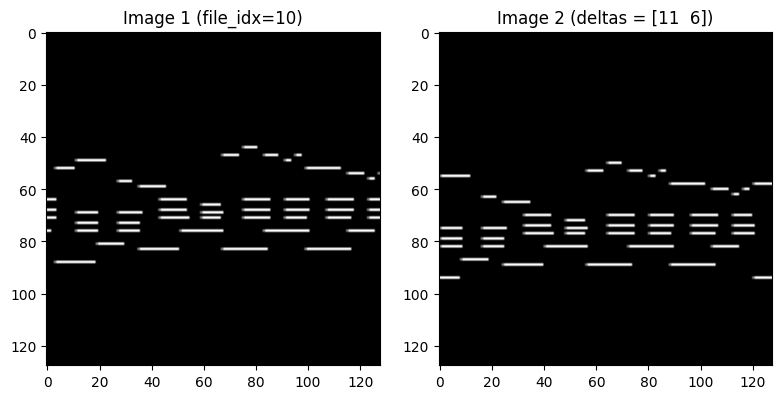

In [ ]:
#| eval: false
# Show a sample image pair
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img1[idx, 0].cpu(), cmap='gray')
axes[0].set_title(f'Image 1 (file_idx={file_idx[idx].item()})')
axes[1].imshow(img2[idx, 0].cpu(), cmap='gray')
axes[1].set_title(f'Image 2 (deltas = {deltas[idx].cpu().int().numpy()})')
plt.tight_layout()
plt.show()

## Load Encoder from Checkpoint

In [ ]:
#| eval: false
ckpt_path = '../checkpoints/enc_best.pt'  # <-- change as needed

model = ViTEncoder(cfg.data.in_channels, (cfg.data.image_size, cfg.data.image_size), 
                   cfg.model.patch_size, cfg.model.dim, cfg.model.depth, cfg.model.heads).to(device)

ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = {k.replace('_orig_mod.', ''): v for k, v in ckpt['model_state_dict'].items()}
model.load_state_dict(state_dict, strict=False)
model.eval()
print(f'Loaded checkpoint from {ckpt_path}, epoch {ckpt.get("epoch", "?")}')

Loaded checkpoint from ../checkpoints/enc_best.pt, epoch 890


## Run Batch Through Encoder

In [ ]:
#| eval: false

with torch.no_grad():
    z1, pmask1 = model(img1, return_cls_only=False)
    z2, pmask2 = model(img2, return_cls_only=False)

z1 = z1.reshape(-1, z1.shape[-1])
z2 = z2.reshape(-1, z2.shape[-1])
num_tokens = z1.shape[0] // len(batch['img1'])

print(f'z1: {z1.shape}, z2: {z2.shape}, num_tokens: {num_tokens}')

z1: torch.Size([49920, 256]), z2: torch.Size([49920, 256]), num_tokens: 65


## Visualize Embeddings

In [ ]:
#| eval: false

# Combined embeddings from both views
zs = torch.stack([z1, z2], dim=1).reshape(-1, z1.shape[-1])
pmasks = (pmask1, pmask2)
#file_idx = file_idx.repeat_interleave(zs.shape[0]//file_idx.shape[0])

coords = pca_project(zs)
fig = plot_embeddings_3d(coords, num_tokens, file_idx=file_idx, title='Embeddings (PCA)')

NameError: name 'torch' is not defined

In [ ]:
#| eval: false
fig.show()

NameError: name 'fig' is not defined

In [ ]:
#| eval: false
figs = make_emb_viz(zs,  num_tokens, epoch=-1, model=None, title='Embeddings', 
                    max_points=4096, pmasks=pmasks, file_idx=file_idx, do_umap=False)
figs.keys()

cls_tokens.shape = torch.Size([1536, 256])


dict_keys(['cls_pca_fig', 'cls_umap_fig', 'patch_pca_fig', 'patch_umap_fig', 'empty_pca_fig'])

In [ ]:
#| eval: false
figs['patch_pca_fig'].show()

NameError: name 'figs' is not defined